<center><h1>Gaussian Process Regression for GB Energy & Mobility Prediction</h1></center>

In [1]:
import matplotlib
matplotlib.use('svg')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 23})

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/gpu:0']


In [2]:
import gpflow
import seaborn as sns
import itertools
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
import numpy as np
import copy
import h5py
import edward as ed
import keras.backend as K
from tensorflow.python.ops import array_ops
from edward.models import Normal, Uniform, MultivariateNormalTriL
from edward.util import rbf
from sklearn.metrics import log_loss
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../fcc1-2.txt", delim_whitespace = True, skiprows = 6, header = None)

#Parse it into a readable column
X = pd.DataFrame(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})

X = pd.DataFrame(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})
i=0
while i < df.shape[0]:
    #print df.ix[i]
    if i==0:
        X =pd.DataFrame([df.ix[i][0],df.ix[i][1],df.ix[i][2],df.ix[i][4],df.ix[i][5],df.ix[i][6], df.ix[i][7]])
    else:
        X = pd.concat([X,pd.DataFrame([df.ix[i][0],df.ix[i][1],df.ix[i][2],df.ix[i][4],df.ix[i][5],df.ix[i][6], df.ix[i][7]])], axis=1)
    i=i+1
    try:
        while ~np.isnan(df.ix[i][6]):
            i=i+1
        while np.isnan(df.ix[i][6]):
            i=i+1
    except KeyError:
        continue

X = X.transpose().rename(columns={0:'r1',1:'r2',2:'r3',3:'disorientation',4:'h1',5:'k1',6:'l1'})

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  # This is added back by InteractiveShellApp.init_path()


In [4]:
print(X.head())
GBChar = np.zeros((len(X),5)) #Five crystallographic degrees of freedom
GBChar[:,0:2] = X.values[:,0:2].astype('float32')
GBChar[:,2] = X.values[:,3].astype('float32')
GBChar[:,3] = X.values[:,4]/np.linalg.norm(X.values[:,4:7].astype('float32'),axis=-1)
GBChar[:,4] = X.values[:,5]/np.linalg.norm(X.values[:,4:7].astype('float32'),axis=-1)

  r1 r2 r3 disorientation h1 k1 l1
0  1  0  0        36.8699  3  1  0
0  1  0  0        36.8699  2  0  0
0  1  1  0        70.5288  2  2  2
0  1  1  0        70.5288  2  1  1
0  1  1  0        70.5288  1  1  0


In [5]:
Mob = pd.read_csv("../fcc2-mobility.txt", delim_whitespace = True)
print(Mob.head())
Mob = Mob.values[:,1]

   GB_index  Mobility  (m/s-GPa)
0         1       121        NaN
1         2       106        NaN
2         3         0        NaN
3         4       210        NaN
4         5      1489        NaN


In [6]:
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
shuffle_in_unison(GBChar,Mob)
Mob = np.expand_dims(Mob,axis=-1)

In [7]:
kernel = gpflow.kernels.RBF(5)
m = gpflow.gpr.GPR(GBChar, Mob, kern=kernel)
m.optimize()

      fun: 2709.6358294085371
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.23573607e-03,   2.57651604e-08,  -1.22214962e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 79
   status: 0
  success: True
        x: array([  6.69720999e+00,   1.03047441e+05,   5.78922618e+04])

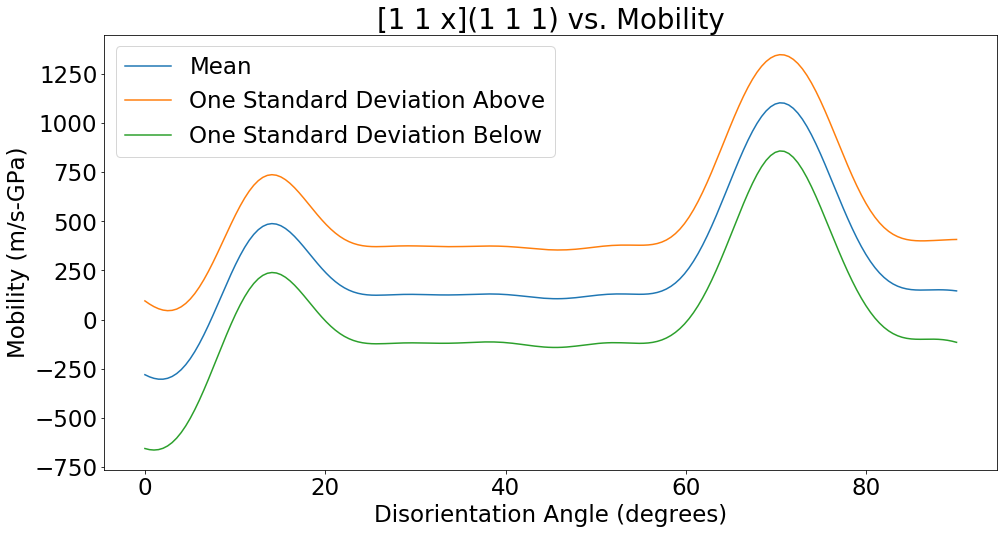

In [8]:
pX = np.expand_dims(np.linspace(0,90,180),axis=-1)
pX = np.concatenate((np.repeat([[1,1]],180,axis=0),pX),axis=-1)
pX = np.concatenate((pX,np.repeat([[1,1]],180,axis=0)/3),axis=-1)
pY, pYv = m.predict_y(pX)
plt.figure(1,figsize=(16,8))
plt.plot(pX[:,2],pY[:,0],label='Mean')
plt.plot(pX[:,2],pY[:,0]+1*pYv[:,0]**0.5,label='One Standard Deviation Above') 
plt.plot(pX[:,2],pY[:,0]-1*pYv[:,0]**0.5,label='One Standard Deviation Below')
plt.title('[1 1 x](1 1 1) vs. Mobility')
plt.xlabel('Disorientation Angle (degrees)')
plt.ylabel('Mobility (m/s-GPa)')
plt.legend()

The dataset doesn't adequately cover Grain-Boundary Parameter space enough to learn very certain predictive models for the Grain Boundary mobility.

However, we can use this model as the basis for an active learning machine that calls the molecular statics subroutine (we can use this model to tell us where our knowledge of Grain Boundary Parameter space is most lacking).